# Transfer Learning and Fine Tuning 

Follows the transfer learning example, adapted to Wes or not Wes instead of dogs and cats. 


https://keras.io/guides/transfer_learning/#an-endtoend-example-finetuning-an-image-classification-model-on-a-cats-vs-dogs-dataset

data structure 

```
data/ 
    not_wes/
        img.jpg
    wes/
        img.jpg
```

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

%load_ext nb_black

2023-02-27 19:45:20.864203: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<IPython.core.display.Javascript object>

In [2]:
image_size = (150, 150)
batch_size = 16

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    "/Users/rory/data/how_much_wes/wes_anderson/data/",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2820 files belonging to 2 classes.
Using 2256 files for training.
Using 564 files for validation.


2023-02-27 19:45:24.912570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<IPython.core.display.Javascript object>

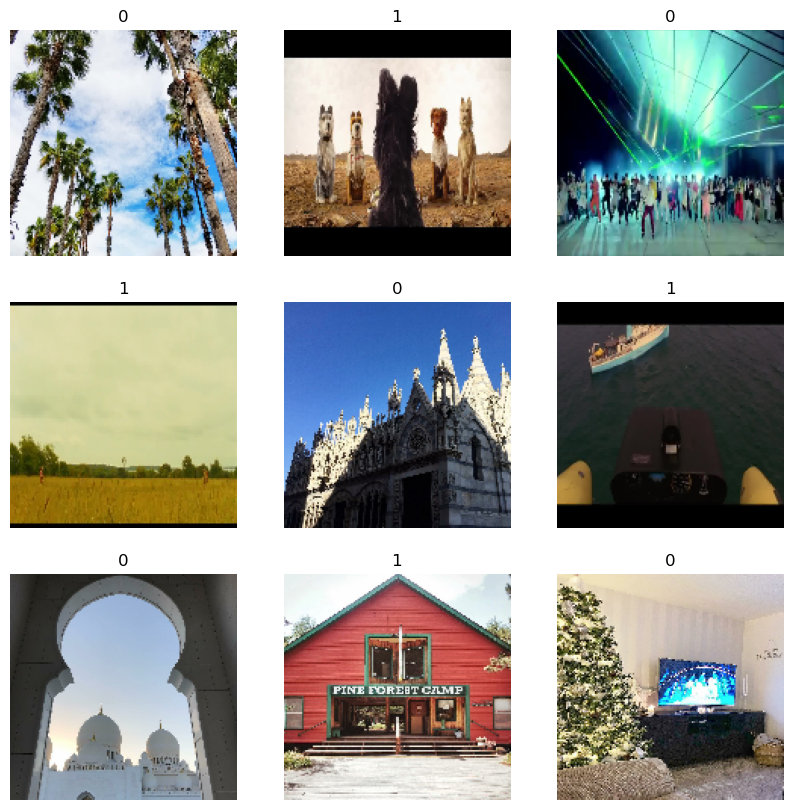

<IPython.core.display.Javascript object>

In [3]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [4]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

<IPython.core.display.Javascript object>

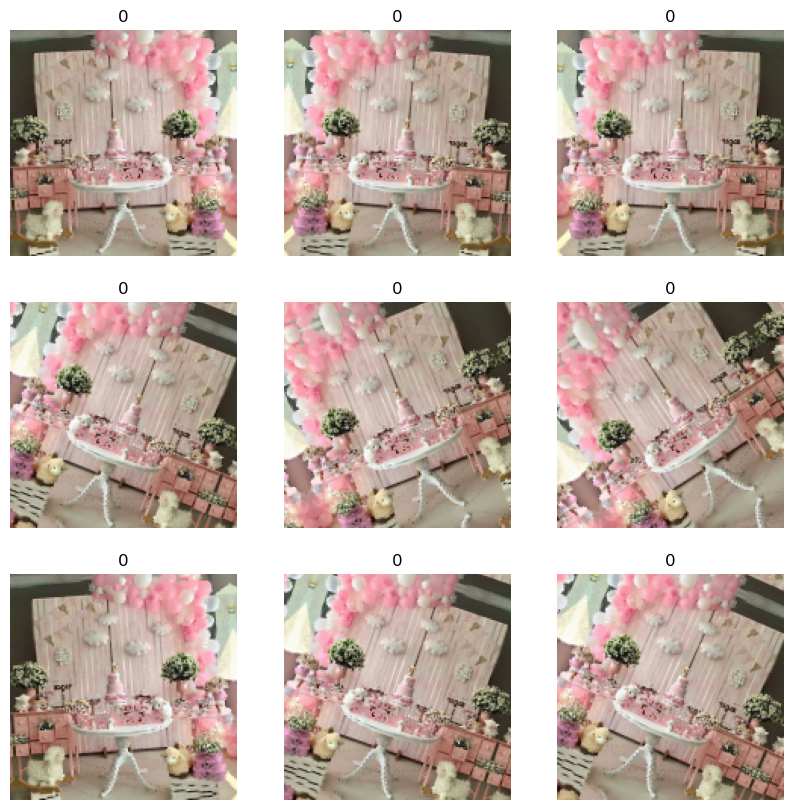

<IPython.core.display.Javascript object>

In [5]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [6]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

<IPython.core.display.Javascript object>

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
141/141 [==============================] - 62s 415ms/step - loss: 0.6194 - accuracy: 0.6494 - val_loss: 0.6027 - val_accuracy: 0.6809
Epoch 2/20
141/141 [==============================] - 58s 407ms/step - loss: 0.5134 - accuracy: 0.7509 - val_loss: 0.5743 - val_accuracy: 0.6879
Epoch 3/20
141/141 [==============================] - 55s 392ms/step - loss: 0.4604 - accuracy: 0.7832 - val_loss: 0.5541 - val_accuracy: 0.7057
Epoch 4/20
141/141 [==============================] - 57s 405ms/step - loss: 0.4461 - accuracy: 0.7939 - val_loss: 0.5653 - val_accuracy: 0.7004
Epoch 5/20
141/141 [==============================] - 57s 404ms/step - loss: 0.4222 - accuracy: 0.8121 - val_loss: 0.5318 - val_accuracy: 0.7305
Epoch 6/20
141/141 [==============================] - 60s 422ms/step - loss: 0.4062 - accuracy: 0.8223 - val_loss: 0.5284 - val_accuracy: 0.7358
Epoch 7/20
141/141 [==============================] - 60s 421ms/step - loss: 0.3917 - accuracy: 0.8382 - val_loss: 0.5155 - val_ac

<IPython.core.display.Javascript object>

In [8]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

<IPython.core.display.Javascript object>

In [10]:
# loaded_model = tf.keras.models.load_model("tuned_xception.tf")

<IPython.core.display.Javascript object>

In [11]:
img = keras.preprocessing.image.load_img(
    "/Users/rory/data/how_much_wes/wes_anderson/data/not_wes/batman_v_superman-0020.jpeg",
    target_size=image_size,
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])  # Wes label is 1
print(f"This image is {100 * score:.2f}% Wes.")

1/1 [==============================] - 1s 770ms/step
This image is 0.85% Wes.


<IPython.core.display.Javascript object>

In [17]:
img = keras.preprocessing.image.load_img(
    "/Users/rory/data/how_much_wes/wes_anderson/data/wes/accidentallywesanderson_19228604_869740716508283_2000572221466083328_n.jpg",
    target_size=image_size,
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(predictions[0])  # Wes label is 1
print(f"This image is {100 * score:.2f}% Wes.")

1/1 [==============================] - 0s 55ms/step
This image is 98.33% Wes.


<IPython.core.display.Javascript object>

In [19]:
model.save("tuned_xception.keras")

<IPython.core.display.Javascript object>